<a href="https://www.kaggle.com/code/clemwo/competition-submission-poisonous-mushrooms?scriptVersionId=194105318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)           

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    confusion_matrix, 
    average_precision_score, 
)

sns.set(style="white")

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


<img src="https://cdn.britannica.com/90/236590-050-27422B8D/Close-up-of-mushroom-growing-on-field.jpg" alt="Mushroom" width="700"/>

# 🔥 Competition Submission : Poisonous Mushrooms 🍄

> This notebooks builds models for Kaggles [Binary Prediction of Poisonous Mushrooms 🍄 competition](https://www.kaggle.com/competitions/playground-series-s4e8/overview). The objective is to develop a model which predicts whether an observation is editable (`e`) or poisonous (`p`). The final output from the predictions of the `test.csv` set should predict the `class` for each row in `test.csv`. The format of the submission file should be as follows: 

```
    id,class
    3116945,e
    3123432,p
```

In [2]:
shrooms = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
print(f"Rows: {shrooms.shape[0]:,}")
print(f"Cols: {shrooms.shape[1]:,}")
print(shrooms.dtypes)
shrooms.head(3)

Rows: 3,116,945
Cols: 22
id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w


- The dataset contains 22 columns, out of which one column is the `id` and one column is the target `class`. 
- Thus, it seems like there are 20 columns to work with for feature engineering. 

In [54]:
class GlobalVars: 
    RANDOM_STATE = 42    
    TARGET = 'class'
    TARGET_BOOL = 'class_boolean'
    
    # Columns which are non-processed and can be used for feng.
    BASE_COLS = shrooms.loc[:, shrooms.columns.difference(['id', 'class'])].columns.tolist()

# 📊 EDA

Let's get an overview of the 🍄 mushroom dataset.

In [4]:
temp = shrooms[GlobalVars.BASE_COLS]

stats = pd.DataFrame({
    'Variable Name': temp.columns,
    'Missing Count': temp.isnull().sum().values,
    'Missing Rate (%)': 100*temp.isnull().mean().values,
    'Unique Count': temp.nunique().values,
    'Unique Rate (%)': 100*temp.nunique().values / len(temp)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
19,veil-type,2957493,94.884350,22,0.000706
12,spore-print-color,2849682,91.425482,32,0.001027
15,stem-root,2757023,88.452732,38,0.001219
18,veil-color,2740947,87.936970,24,0.000770
16,stem-surface,1980861,63.551362,60,0.001925
7,gill-spacing,1258435,40.373988,48,0.001540
3,cap-surface,671023,21.528227,83,0.002663
5,gill-attachment,523936,16.809280,78,0.002502
10,ring-type,128880,4.134818,40,0.001283
6,gill-color,57,0.001829,63,0.002021


We see a couple of columns have relatively high missing rates. 

- `vei-type`, `spore-print-color`, `stem-root`, `veil-color`, `stem-surface` all have missing rates above 50% and could therefore be totally be removed (for now).
- `gill-spacing`, `cap-surface` and `gill-attachment` have missing rates of 40%, 21% and 16% respectively. These are column which we could possibly work with even though the missing rates are still non neglectable.
- Allother columns have low missing rates.

For now let's choose a aggressive threshold for the missing rates (e.g. 10%) to come up quickly with a model. 

In [5]:
MISSING_RATE_THRESH = 10

cols_with_low_missingness = stats[stats['Missing Rate (%)'] < MISSING_RATE_THRESH]['Variable Name'].values.tolist()
print(shrooms[cols_with_low_missingness].dtypes)
shrooms[cols_with_low_missingness].head(5)

ring-type                object
gill-color               object
habitat                  object
cap-shape                object
stem-color               object
has-ring                 object
cap-color                object
does-bruise-or-bleed     object
cap-diameter            float64
season                   object
stem-height             float64
stem-width              float64
dtype: object


,ring-type,gill-color,habitat,cap-shape,stem-color,has-ring,cap-color,does-bruise-or-bleed,cap-diameter,season,stem-height,stem-width
0,f,w,d,f,w,f,u,f,8.80,a,4.51,15.39
1,z,n,d,x,o,t,o,f,4.51,w,4.79,6.48
2,f,w,l,f,n,f,b,f,6.94,w,6.85,9.93
3,f,g,d,f,w,f,g,f,3.88,u,4.16,6.53
4,f,w,g,x,w,f,w,f,5.85,a,3.37,8.36


For easier analysis, we will convert the target `class` to boolean.

In [34]:
shrooms[GlobalVars.TARGET_BOOL] = shrooms[GlobalVars.TARGET].map({'p': 1, 'e': 0})
print("Percentage per target value")
print("===========================")
100*shrooms[GlobalVars.TARGET_BOOL].value_counts(normalize=True)

Percentage per target value


class_boolean
1    54.713702
0    45.286298
Name: proportion, dtype: float64

## 📈 Numerical Columns

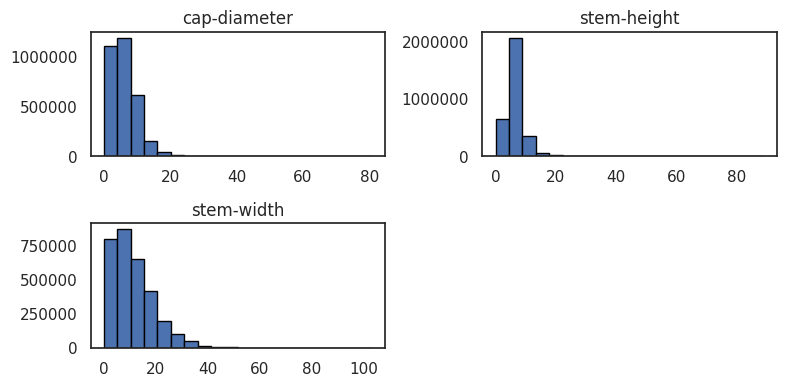

In [6]:
float64_columns = shrooms[cols_with_low_missingness].select_dtypes(include=['float64'])

fig, axes = plt.subplots(2, 2, figsize=(8, 4))
axes = axes.flatten()

for i, col in enumerate(float64_columns):
    ax = axes[i]
    ax.hist(shrooms[col].dropna(), bins=20, edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

Let's take a look at the correlation of each numerical variable to the target `class`. 

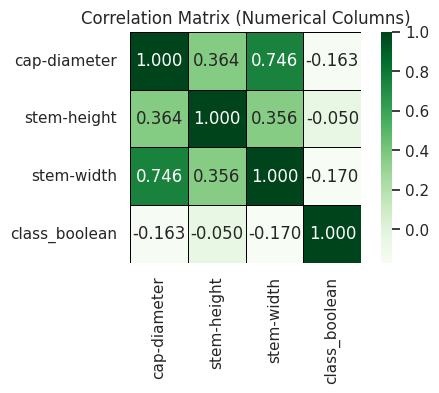

In [38]:
corr_matrix = shrooms[float64_columns.columns.tolist() + [GlobalVars.TARGET_BOOL]].corr()

plt.figure(figsize=(5, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='Greens', 
            cbar=True, linewidths=0.5, linecolor='black', square=True)
plt.title('Correlation Matrix (Numerical Columns)')

plt.show()

- `stem-width` and the target `class` have a high correlation of 0.7.
- `stem-height` and the target `class` also have a non-neglectable, but smaller correlation of 0.3.
- `cap-diameter` and the target `class` have a slight negative correlation.

In [47]:
numerical_columns = float64_columns.columns.tolist()

## 🗂️ Categorical Columns

In this section we are going to investigate the categorical columns and their relationship to the target.

In [22]:
object_columns = shrooms[[GlobalVars.TARGET] + cols_with_low_missingness].select_dtypes(include=['object'])
object_columns_without_target = [x for x in object_columns.columns.tolist() if x != GlobalVars.TARGET]
unique_counts_df = pd.DataFrame()

for column in object_columns_without_target:
    unique_counts = shrooms.groupby(GlobalVars.TARGET)[column].nunique()
    unique_counts_df[column] = unique_counts

unique_counts_df = unique_counts_df.T
unique_counts_df.rename(columns={'e': 'Editable', 'p': 'Poisonous'}, inplace=True)

# Calculate the percentages of distinct values per class and by target.
# This answer the question: 
#     Out of all distinct values of class ring-type, how many percent are editable, how many are poisonous?
unique_counts_df['Editable (%)'] = round(100*unique_counts_df['Editable'] / 
                                             (unique_counts_df['Editable'] + unique_counts_df['Poisonous']), 2)
unique_counts_df['Poisonous (%)'] = round(100*unique_counts_df['Poisonous'] / 
                                             (unique_counts_df['Editable'] + unique_counts_df['Poisonous']), 2)

# How big is the difference in the percentages? The bigger the more interesting.
unique_counts_df['Delta %'] = abs(unique_counts_df['Editable (%)'] - unique_counts_df['Poisonous (%)'])

print(f"Number of distinct values for categorical columns, grouped by the target.")
print("==========================================================================")
unique_counts_df

Number of distinct values for categorical columns, grouped by the target.


class,Editable,Poisonous,Editable (%),Poisonous (%),Delta %
ring-type,30,34,46.88,53.12,6.24
gill-color,48,45,51.61,48.39,3.22
habitat,40,38,51.28,48.72,2.56
cap-shape,54,43,55.67,44.33,11.34
stem-color,44,38,53.66,46.34,7.32
has-ring,15,20,42.86,57.14,14.28
cap-color,56,49,53.33,46.67,6.66
does-bruise-or-bleed,21,19,52.50,47.50,5.00
season,4,4,50.00,50.00,0.00


Seems like there are not obvious difference per target value for any of the categorical variables. The highest difference is for `has-ring` where Posionous distinct `has-ring` categories are 14% more than Editable distinct `has-ring` categories. 

### Chi-Squared Test
Let's investigate if there are any significant relationships between the categorical features and the target `class`. We will perform the classical Chi-Squared test for that. 

In [8]:
from scipy.stats import chi2_contingency

chi2_results = {}
for column in object_columns_without_target:
    cross_tab = pd.crosstab(shrooms[column], shrooms[GlobalVars.TARGET])
    chi2, p, dof, ex = chi2_contingency(cross_tab)
    chi2_results[column] = p

chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p-value'])
print(chi2_df)

                      p-value
ring-type                 0.0
gill-color                0.0
habitat                   0.0
cap-shape                 0.0
stem-color                0.0
has-ring                  0.0
cap-color                 0.0
does-bruise-or-bleed      0.0
season                    0.0


Note that the $p$-value represents the probability that the observed association between the feature and the target variable is due to chance. A very low $p$-value (below a threshold like 0.05) suggests that the observed association is statistically significant, meaning there is likely a relationship between the feature and the target variable.

- All the $p$-values are effectively 0.0, which indicates that the association between each categorical feature (e.g., ring-type, gill-color, habitat, etc.) and the target variable `class` is statistically significant.
- This means we can reject the null hypothesis $H_0$ that these features are independent of the target variable. 
- Instead, it suggests that these features are likely related to the target in a meaningful way. This could be helpful for model development without any fancy feature engineering yet. 

### Label-Encoding & Distributions

Label Encoding Distributions


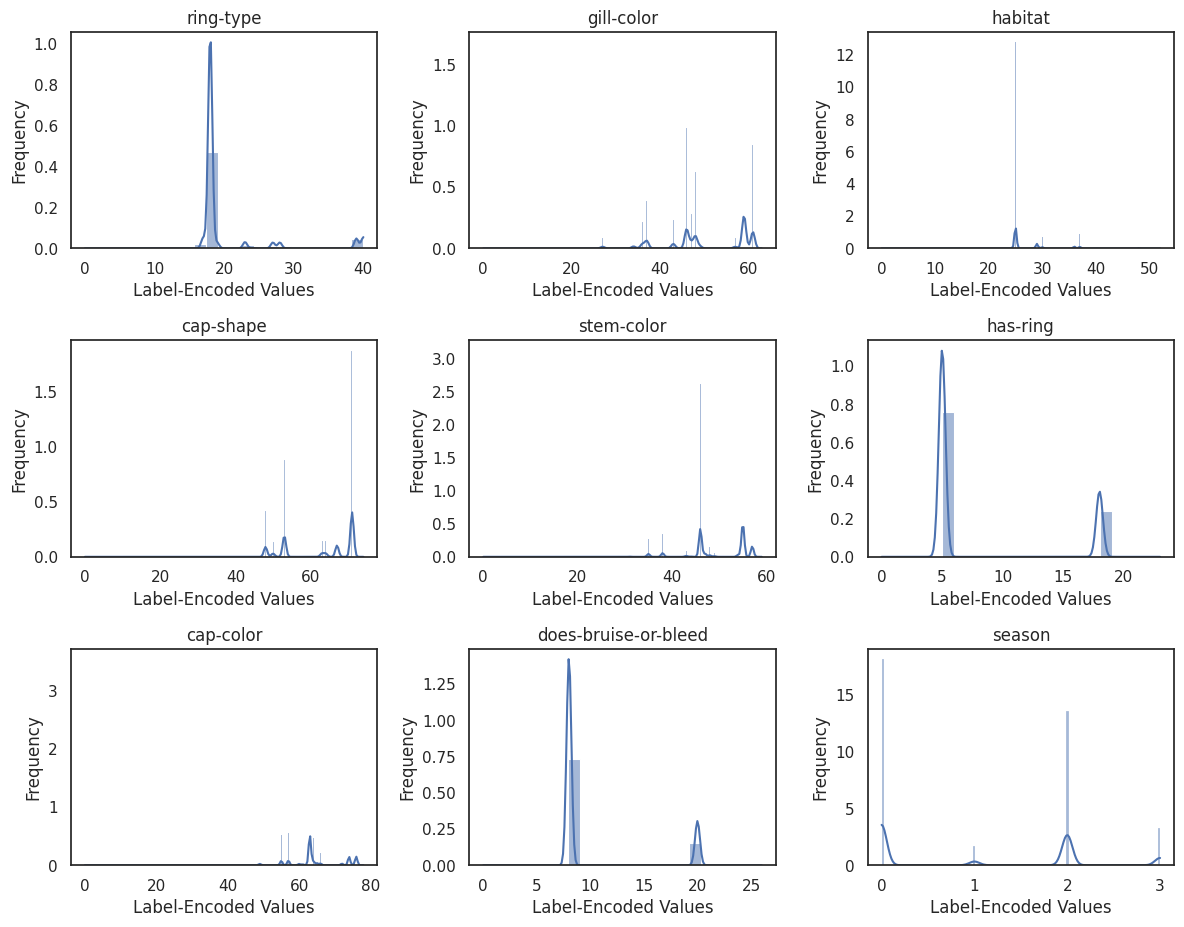

In [52]:
shrooms_encoded = shrooms.copy()

label_encoders = {}               # To save all our label encoders.
encoded_categorical_columns = []  # To save all the created new features.

plt.figure(figsize=(12, 12))

print("Label Encoding Distributions")
print("============================")
for i, column in enumerate(object_columns_without_target, 1):
    label_encoder = LabelEncoder()
    
    # Fit the label encoder.
    shrooms_encoded[f'{column}_encoded'] = label_encoder.fit_transform(shrooms_encoded[column])
    encoded_categorical_columns.append(f'{column}_encoded')  
    
    # Save the fitted label encoder.
    label_encoders[column] = label_encoder    
    
    # Plot the distribution.
    plt.subplot(len(object_columns_without_target) // 3 + 1, 3, i)
    sns.histplot(shrooms_encoded[f'{column}_encoded'], stat='density', kde=True, kde_kws={'bw_adjust': 1})
    plt.title(f'{column}')
    plt.xlabel('Label-Encoded Values')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

### Cardinalities

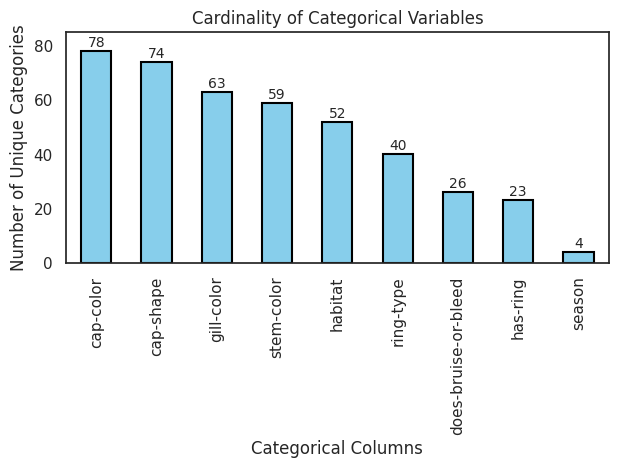

In [12]:
cardinality = shrooms[object_columns_without_target].nunique().sort_values(ascending=False)

plt.figure(figsize=(7, 3))
ax = cardinality.plot(kind='bar', color='skyblue', edgecolor='black', linewidth=1.5)

for index, value in enumerate(cardinality):
    ax.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Cardinality of Categorical Variables')
plt.ylabel('Number of Unique Categories')
plt.xlabel('Categorical Columns')
plt.xticks(rotation=90)
plt.ylim((0, 85))
plt.show()

# 🛠️ Pre-Processing & Feature Engineering

Before we can train a model we need to perform some preprocessing steps.

In [55]:
features = numerical_columns + encoded_categorical_columns

In [56]:
shrooms_encoded[
    [GlobalVars.TARGET_BOOL] + features
].head(3)

,class_boolean,cap-diameter,stem-height,stem-width,ring-type_encoded,gill-color_encoded,habitat_encoded,cap-shape_encoded,stem-color_encoded,has-ring_encoded,cap-color_encoded,does-bruise-or-bleed_encoded,season_encoded
0,0,8.80,4.51,15.39,18,59,25,53,55,5,72,8,0
1,1,4.51,4.79,6.48,39,46,25,71,47,18,64,8,3
2,0,6.94,6.85,9.93,18,59,36,53,46,5,49,8,3


In [57]:
# ------------------- #
# Define training set #
# ------------------- #

X = shrooms_encoded[features]
y = shrooms_encoded[GlobalVars.TARGET_BOOL]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=GlobalVars.RANDOM_STATE)

print(f"""Shapes:
    X_train: {X_train.shape[0]:,} (rows) {X_train.shape[1]:,} (cols)
    y_train: {y_train.shape[0]:,} (rows)
    
    X_val: {X_val.shape[0]:,} (rows) {X_val.shape[1]:,} (cols)
    y_val: {y_val.shape[0]:,} (rows)    
""")
X_train.head(3)

Shapes:
    X_train: 2,493,556 (rows) 12 (cols)
    y_train: 2,493,556 (rows)
    
    X_val: 623,389 (rows) 12 (cols)
    y_val: 623,389 (rows)    



,cap-diameter,stem-height,stem-width,ring-type_encoded,gill-color_encoded,habitat_encoded,cap-shape_encoded,stem-color_encoded,has-ring_encoded,cap-color_encoded,does-bruise-or-bleed_encoded,season_encoded
1252551,2.58,2.87,5.69,18,46,25,67,46,5,63,20,0
1799166,1.83,5.36,2.70,18,46,37,48,46,5,64,8,0
1936146,5.22,7.32,7.41,18,61,37,71,43,5,64,8,0


In [64]:
# -------------------- #
# Prepare the test set #
# -------------------- #

test_raw = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
print(f"Rows: {test_raw.shape[0]:,}")
print(f"Cols: {test_raw.shape[1]:,}")
print(test_raw.dtypes)
test_raw.head(3)

Rows: 2,077,964
Cols: 21
id                        int64
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s


In [72]:
# ------------------------------------------- #
# Apply the previously fitted label encoders. #
# Ignore unseen labels.                       #
# ------------------------------------------- #

print(f"Starting label encoding...")
for column, encoder in label_encoders.items():
    print(f"Processing column: {column}")
    
    known_classes = set(encoder.classes_)
    test_raw[column] = np.where(test_raw[column].isin(known_classes), test_raw[column], 'unknown')
    encoder.classes_ = np.append(encoder.classes_, 'unknown')
    
    test_raw[f'{column}_encoded'] = encoder.transform(test_raw[column])
    
    unknown_encoded = encoder.transform(['unknown'])[0]
    test_raw[f'{column}_encoded'] = np.where(test_raw[f'{column}_encoded'] == unknown_encoded, -1, test_raw[f'{column}_encoded'])

print("Finished label encoding!")

Starting label encoding...
Processing column: ring-type
Processing column: gill-color
Processing column: habitat
Processing column: cap-shape
Processing column: stem-color
Processing column: has-ring
Processing column: cap-color
Processing column: does-bruise-or-bleed
Processing column: season
Finished label encoding!


# 🤖 Modeling

In this section we are going to train the model using a LightGBM classifier. Since the training (on CPU) took already lot's of time we didn't perform hyperparameter tuning yet. 

In [ ]:
from lightgbm import LGBMClassifier, early_stopping

model = LGBMClassifier(random_state=GlobalVars.RANDOM_STATE, verbose=-1)
model.fit(X_train, y_train)

In [59]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

acc_train = accuracy_score(y_train, y_train_pred)
report_train = classification_report(y_train, y_train_pred)

acc_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)

print(f"{20*'='} TRAIN {20*'='}")
print(f"Accuracy: {acc_train:.2f}")
print(f"Classification Report: {report_train}")
print()
print(f"{20*'='} VALIDATION {20*'='}")
print(f"Accuracy: {acc_val:.2f}")
print(f"Classification Report: {report_val}")

==================== TRAIN ====================
Accuracy: 0.97
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.97      0.96   1129152
           1       0.97      0.97      0.97   1364404

    accuracy                           0.97   2493556
   macro avg       0.97      0.97      0.97   2493556
weighted avg       0.97      0.97      0.97   2493556


==================== VALIDATION ====================
Accuracy: 0.97
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.97      0.96    282397
           1       0.97      0.97      0.97    340992

    accuracy                           0.97    623389
   macro avg       0.97      0.97      0.97    623389
weighted avg       0.97      0.97      0.97    623389



In [60]:
y_train_proba = model.predict_proba(X_train)[:, 1]
y_val_proba = model.predict_proba(X_val)[:, 1]

# Define a range of thresholds to evaluate.
thresholds = np.arange(0.1, 1.0, 0.1)

print(f"{20*'='} TRAIN {20*'='}")
for threshold in thresholds:
    y_train_pred_threshold = (y_train_proba >= threshold).astype(int)
    acc_train = accuracy_score(y_train, y_train_pred_threshold)
    prec_train = precision_score(y_train, y_train_pred_threshold)
    rec_train = recall_score(y_train, y_train_pred_threshold)
    print(f"Threshold: {threshold:.2f} - Accuracy: {acc_train:.2f}  Precision: {prec_train:.2f}  Recall: {rec_train:.2f}")

print()
print(f"{20*'='} VALIDATION {20*'='}")
for threshold in thresholds:
    y_val_pred_threshold = (y_val_proba >= threshold).astype(int)
    acc_val = accuracy_score(y_val, y_val_pred_threshold)
    prec_val = precision_score(y_val, y_val_pred_threshold)
    rec_val = recall_score(y_val, y_val_pred_threshold)    
    print(f"Threshold: {threshold:.2f} - Accuracy: {acc_val:.2f}  Precision: {prec_val:.2f}  Recall: {rec_val:.2f}")    

==================== TRAIN ====================
Threshold: 0.10 - Accuracy: 0.86  Precision: 0.80  Recall: 0.99
Threshold: 0.20 - Accuracy: 0.94  Precision: 0.91  Recall: 0.99
Threshold: 0.30 - Accuracy: 0.96  Precision: 0.95  Recall: 0.98
Threshold: 0.40 - Accuracy: 0.97  Precision: 0.96  Recall: 0.98
Threshold: 0.50 - Accuracy: 0.97  Precision: 0.97  Recall: 0.97
Threshold: 0.60 - Accuracy: 0.97  Precision: 0.98  Recall: 0.96
Threshold: 0.70 - Accuracy: 0.96  Precision: 0.99  Recall: 0.94
Threshold: 0.80 - Accuracy: 0.94  Precision: 0.99  Recall: 0.90
Threshold: 0.90 - Accuracy: 0.88  Precision: 1.00  Recall: 0.78

==================== VALIDATION ====================
Threshold: 0.10 - Accuracy: 0.86  Precision: 0.80  Recall: 0.99
Threshold: 0.20 - Accuracy: 0.94  Precision: 0.91  Recall: 0.99
Threshold: 0.30 - Accuracy: 0.96  Precision: 0.95  Recall: 0.98
Threshold: 0.40 - Accuracy: 0.97  Precision: 0.96  Recall: 0.98
Threshold: 0.50 - Accuracy: 0.97  Precision: 0.97  Recall: 0.97
Th

In [62]:
results = {
    "threshold": [],
    "train_accuracy": [],
    "train_precision": [],
    "train_recall": [],
    "val_accuracy": [],
    "val_precision": [],
    "val_recall": []
}

for threshold in thresholds:
    y_train_pred_threshold = (y_train_proba >= threshold).astype(int)
    y_val_pred_threshold = (y_val_proba >= threshold).astype(int)
    
    results["threshold"].append(threshold)
    results["train_accuracy"].append(accuracy_score(y_train, y_train_pred_threshold))
    results["train_precision"].append(precision_score(y_train, y_train_pred_threshold))
    results["train_recall"].append(recall_score(y_train, y_train_pred_threshold))
    
    results["val_accuracy"].append(accuracy_score(y_val, y_val_pred_threshold))
    results["val_precision"].append(precision_score(y_val, y_val_pred_threshold))
    results["val_recall"].append(recall_score(y_val, y_val_pred_threshold))

results_df = pd.DataFrame(results)
results_df

,threshold,train_accuracy,train_precision,train_recall,val_accuracy,val_precision,val_recall
0,0.1,0.859357,0.798027,0.994716,0.859321,0.798017,0.994539
1,0.2,0.941793,0.912568,0.988311,0.941436,0.912113,0.988149
2,0.3,0.960857,0.947254,0.983211,0.960710,0.947064,0.983123
3,0.4,0.966582,0.963268,0.976149,0.966535,0.963414,0.975879
4,0.5,0.967735,0.973305,0.967571,0.967451,0.973271,0.967052
5,0.6,0.965609,0.981544,0.955106,0.965469,0.981486,0.954885
6,0.7,0.958422,0.987240,0.936113,0.958296,0.987100,0.935990
7,0.8,0.940442,0.991701,0.898673,0.940361,0.991389,0.898778
8,0.9,0.876967,0.995292,0.778832,0.876705,0.995178,0.778367


# 🎯 Predict on the test set

In this section we are predicting on the `test.csv` file. The final file to submit for the competition should be called `submission.csv` and should contain 2 columns, as follows: 

```
    id,class
    3116945,p
    3116946,e    
```

In [73]:
test_raw[features].head(3)

,cap-diameter,stem-height,stem-width,ring-type_encoded,gill-color_encoded,habitat_encoded,cap-shape_encoded,stem-color_encoded,has-ring_encoded,cap-color_encoded,does-bruise-or-bleed_encoded,season_encoded
0,8.64,11.13,17.12,19,59,25,71,55,18,63,20,0
1,6.90,1.27,10.75,18,61,25,63,46,5,64,8,0
2,2.00,6.18,3.14,18,46,25,48,46,5,63,8,1


In [78]:
X_test = test_raw[features]

THRESH = 0.7
y_test_preds = [1 if x>THRESH else 0 for x in model.predict_proba(X_test)[:, 1]]
y_test_preds = np.array(y_test_preds)

cnt_editable = np.sum(y_test_preds == 0)
cnt_poisonous = np.sum(y_test_preds == 1)

print(f"In the test set, the model predicts {cnt_poisonous:,} ({100*cnt_poisonous/(cnt_editable+cnt_poisonous):2.2f} %) as poisonous (1).")
print(f"In the test set, the model predicts {cnt_editable:,} ({100*cnt_editable/(cnt_editable+cnt_poisonous):2.2f} %) as editable (0).")

# Convert back to 'p' for poisonous (1) and 'e' for editable (0).
y_test_preds_as_class = ['p' if x==1 else 'e' for x in y_test_preds]

submission_df = pd.DataFrame({
    'id': test_raw['id'],
    'class': y_test_preds_as_class
})
submission_df.head(3)

In the test set, the model predicts 1,077,234 (51.84 %) as poisonous (1).
In the test set, the model predicts 1,000,730 (48.16 %) as editable (0).


,id,class
0,3116945,e
1,3116946,p
2,3116947,p


In [79]:
submission_df.to_csv('submission.csv', index=False)

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏